# Cross-validation
Once we develop a rule-based or ML-based strategy, it's time to backtest it. The first time around we obtain a low Sharpe ratio we're unhappy with, we decide to tweak our strategy. Eventually, after multiple iterations of tweaking parameters, we end up with a "flawless" combination of parameters and a strategy with an exceptional Sharpe ratio. However, in live trading the performance took a different turn: we essentially tanked and lost money. What went wrong?

Markets inherently have noise - small and frequent idiosyncrasies in the price data. When modelling a strategy, we want to avoid optimizing for one specific period because there is a chance the model adapts so closely to historical data that it becomes ineffective in predicting the future. It'd be like tuning a car specifically for one racetrack, while expecting it to perform well everywhere. Especially with vectorbt, which enables us to search extensive databases of historical market data for patterns, it is often possible to develop elaborate rules that appear to predict price development with close accuracy (see p-hacking) but make random guesses when applied to data outside the sample the model was constructed from.

Overfitting (aka curve fitting) usually occurs for one or more of the following reasons: mistaking noise for signal, and overly tweaking too many parameters. To curb overfitting, we should use cross-validation (CV), which involves partitioning a sample of data into complementary subsets, performing the analysis on one subset of data called the training or in-sample (IS) set, and validating the analysis on the other subset of data called the validation or out-of-sample (OOS) set. This procedure is repeated until we have multiple OOS periods and can draw statistics from these results combined. The ultimate questions we need to ask ourselves: is our choice of parameters robust in the IS periods? Is our performance robust on the OOS periods? Because if not, we're shooting in the dark, and as a quant investor we should not leave room for second-guessing when real money is at stake.

Consider a simple strategy around a moving average crossover.

First, we'll pull some data:

In [1]:
import numpy as np
import pandas as pd
from numba import njit
import vectorbtpro as vbt
vbt.settings.set_theme("dark")
vbt.settings.plotting["layout"]["width"] = 800
vbt.settings.plotting['layout']['height'] = 200
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42) # random forest classifier


/Users/ericervin/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


pull in some data

Let's construct a parameterized mini-pipeline that takes data and the parameters, and returns the Sharpe ratio that should reflect the performance of our strategy on that test period:

### Modeling
The class Splitter can also be helpful in cross-validating ML models. In particular, you can casually step upon a class SKLSplitter that acts as a regular cross-validator from scikit-learn by subclassing BaseCrossValidator. We'll demonstrate its usage on a simple classification problem of predicting the best entry and exit timings.

Before we start, we need to decide on features and labels that should act as predictor and response variables respectively. Features are usually multi-columnar time-series DataFrames where each row contains multiple data points (one per column) that should predict the same row in labels. Labels are usually a single-columnar time-series Series that should be predicted. Ask yourself the following questions to easily come up with a decision:

"How can the future performance be represented, preferably as a single number? Should it be the price at the next bar, the average price change over the next week, a vector of weights for rebalancing, a boolean containing a signal, or something else?"
"What kind of data that encompasses the past performance is likely to predict the future performance? Should it be indicators, news sentiment index, past backtesting results, or something else?"
"Which ML model can handle such a task?" (remember that most models are limited to just a couple of specific feature and label formats!)
For the sake of an example, we'll fit a random forest classifier on all TA-Lib indicators stacked along columns to predict the binary labels generated by the label generator TRENDLB, where 1 means an uptrend and 0 means a downtrend. Sounds like fun 😌

Build a pipeline to impute and (standard-)normalize the data, [reduce the dimensionality](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html) of the features, as well as fit one of the [linear](https://scikit-learn.org/stable/modules/linear_model.html) models to predict the average price change over the next n bars (i.e., regression task!). Based on each prediction, you can then decide whether a position is worth opening or closing out. 

# Let's experiment

Smaller resolution but using dollar bars

In [2]:
data_path = '/Users/ericervin/Documents/Coding/data-repository/data/BTCUSDT_1m_futures.pkl' 

futures_1m = vbt.BinanceData.load(data_path)


# Helper functions
Create dollar bars and add them to the original df

In [3]:

def dollar_bar_func(ohlc_df, dollar_bar_size):
    # Calculate dollar value traded for each row
    ohlc_df['DollarValue'] = ohlc_df['Close'] * ohlc_df['Volume']
    
    # Calculate cumulative dollar value
    ohlc_df['CumulativeDollarValue'] = ohlc_df['DollarValue'].cumsum()
    
    # Determine the number of dollar bars
    num_bars = int(ohlc_df['CumulativeDollarValue'].iloc[-1] / dollar_bar_size)
    
    # Generate index positions for dollar bars
    bar_indices = [0]
    cumulative_value = 0
    for i in range(1, len(ohlc_df)):
        cumulative_value += ohlc_df['DollarValue'].iloc[i]
        if cumulative_value >= dollar_bar_size:
            bar_indices.append(i)
            cumulative_value = 0
    
    # Create a new dataframe with dollar bars
    dollar_bars = []
    for i in range(len(bar_indices) - 1):
        start_idx = bar_indices[i]
        end_idx = bar_indices[i + 1]
        
        dollar_bar = {
            'Open': ohlc_df['Open'].iloc[start_idx],
            'High': ohlc_df['High'].iloc[start_idx:end_idx].max(),
            'Low': ohlc_df['Low'].iloc[start_idx:end_idx].min(),
            'Close': ohlc_df['Close'].iloc[end_idx],
            'Volume': ohlc_df['Volume'].iloc[start_idx:end_idx].sum(),
            'Quote volume': ohlc_df['Quote volume'].iloc[start_idx:end_idx].sum(),
            'Trade count': ohlc_df['Trade count'].iloc[start_idx:end_idx].sum(),
            'Taker base volume': ohlc_df['Taker base volume'].iloc[start_idx:end_idx].sum(),
            'Taker quote volume': ohlc_df['Taker quote volume'].iloc[start_idx:end_idx].sum()
        }
        
        if isinstance(ohlc_df.index, pd.DatetimeIndex):
            dollar_bar['Open Time'] = ohlc_df.index[start_idx]
            dollar_bar['Close Time'] = ohlc_df.index[end_idx] - pd.Timedelta(milliseconds=1)
        elif 'Open Time' in ohlc_df.columns:
            dollar_bar['Open Time'] = ohlc_df['Open Time'].iloc[start_idx]
            dollar_bar['Close Time'] = ohlc_df['Open Time'].iloc[end_idx] - pd.Timedelta(milliseconds=1)
        
        dollar_bars.append(dollar_bar)
    
    dollar_bars_df = pd.concat([pd.DataFrame([bar]) for bar in dollar_bars], ignore_index=True)
    
    return dollar_bars_df

# Create a simple function to simplify the number so we can use it in our column names
def simplify_number(num):
    """
    Simplifies a large number by converting it to a shorter representation with a suffix (K, M, B).
    simplify_number(1000) -> 1K
    """
    suffixes = ['', 'K', 'M', 'B']
    suffix_index = 0

    while abs(num) >= 1000 and suffix_index < len(suffixes) - 1:
        num /= 1000.0
        suffix_index += 1

    suffix = suffixes[suffix_index] if suffix_index > 0 else ''
    simplified_num = f'{int(num)}{suffix}'

    return simplified_num

def merge_and_fill_dollar_bars(original_df, dollar_bars_df, dollar_bar_size):
    # Add prefix to column names in dollar bars dataframe
    dollar_bar_prefix = f'db_{simplify_number(dollar_bar_size)}_'
    dollar_bars_df_renamed = dollar_bars_df.add_prefix(dollar_bar_prefix)

    # Convert 'Open Time' columns to pandas datetime format and set them as index
    dollar_bars_df_renamed.index = pd.to_datetime(dollar_bars_df_renamed[dollar_bar_prefix + 'Open Time'])

    # Merge the dataframes on the index
    merged_df = original_df.merge(dollar_bars_df_renamed, how='left', left_index=True, right_index=True)

    # Set the flag for a new dollar bar with prefix
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = ~merged_df[dollar_bar_prefix + 'Close'].isna()

    # Forward fill the NaN values for all columns except the new dollar bar flag
    columns_to_ffill = [col for col in merged_df.columns if col != dollar_bar_prefix + 'NewDBFlag']
    merged_df[columns_to_ffill] = merged_df[columns_to_ffill].fillna(method='ffill')

    # Fill the remaining NaN values in the new dollar bar flag column with False
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = merged_df[dollar_bar_prefix + 'NewDBFlag'].fillna(False)
    
    # Assign the renamed 'Open Time' column back to the dataframe
    merged_df[dollar_bar_prefix + 'Open Time'] = merged_df[dollar_bar_prefix + 'Open Time']

    return merged_df





# Calculate DB
Calc Dollar bars and then add technical analysis features

Uncomment this section if you want to run different size dollar bars

In [ ]:
# dollar_bar_size = 90_000_000
# btc_dollar_bars = dollar_bar_func(futures_1m.get(), dollar_bar_size=dollar_bar_size)
# btc_dollar_bars.index = pd.to_datetime(btc_dollar_bars['Open Time'])
# btc_dollar_bars.shape

In [ ]:
# Convert the dataframe back into a vbt data object
# btc_90M_db_vbt = vbt.BinanceData.from_data(btc_dollar_bars)


In [ ]:
# Save the dollarbars to a pickle file
# btc_90M_db_vbt.save('btc_90M_db_vbt.pkl')

# Load the dollar bars from pickle file

In [111]:
btc_90M_db_vbt = vbt.BinanceData.load('btc_90M_db_vbt.pkl')

Take a small slice of the data

In [255]:
data = btc_90M_db_vbt['2021-01-01':'2023-01-01']
outofsample_data = btc_90M_db_vbt['2023-01-01':'2023-06-03']
data.shape

(105949,)

# Generate features for the model

In [244]:
import talib
print(talib.get_function_groups())
# Not sure how to call just a single indicator group so I'll just call all of them
vbt.IF.list_indicators("psar")

{'Cycle Indicators': ['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE'], 'Math Operators': ['ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM'], 'Math Transform': ['ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH'], 'Momentum Indicators': ['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR'], 'Overlap Studies': ['BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA'], 'Pattern Recognition': ['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHO

['pandas_ta:PSAR']

In [245]:

n = 150 # number of periods in the future to predict

# Generate the features (X) using TA-Lib indicators
# X = data.run("talib", periods=vbt.run_func_dict(mavp=n))
X = data.get()
psar_vbt = data.run("pandas_ta:PSAR", append=True, acceleration=0.02, maximum=0.2)
# add trend label as a feature
X['trend'] = data.run("trendlb", .2, 0.05, mode="binary").labels # add trend label as a feature
# X['psar_cross'] = psar_vbt.psarr

# Add time features
X['dayofmonth'] = X.index.day
X['month'] = X.index.month
X['year'] = X.index.year
X['hour'] = X.index.hour
X['minute'] = X.index.minute
X['dayofweek'] = X.index.dayofweek
X['dayofyear'] = X.index.dayofyear

# Now we are trying to generate future price predictions so we will set the y labels to the price change n periods in the future
y = (data.close.shift(-n) / data.close - 1).rolling(n).mean() # future price change we use rolling mean to smooth the data

# Preprocessing steps to handle NaNs
X = X.replace([-np.inf, np.inf], np.nan) # replace inf with nan
invalid_column_mask = X.isnull().all(axis=0) | (X.nunique() == 1) # drop columns that are all nan or have only one unique value
X = X.loc[:, ~invalid_column_mask] # drop invalid columns
invalid_row_mask = X.isnull().any(axis=1) | y.isnull() # drop rows that have nan in any column or in y

# Drop invalid rows in X and y
X = X.loc[~invalid_row_mask]
y = y.loc[~invalid_row_mask]

In [246]:
X

,Open,High,Low,Close,...,hour,minute,dayofweek,dayofyear
Open Time,,,,,,,,,
2021-01-02 16:21:00+00:00,32364.11,32455.00,32231.72,32383.03,...,16,21,5,2
2021-01-02 16:25:00+00:00,32402.48,32432.38,32233.59,32349.34,...,16,25,5,2
2021-01-02 16:29:00+00:00,32312.27,32555.98,32299.93,32521.29,...,16,29,5,2
2021-01-02 16:32:00+00:00,32520.71,32814.23,32468.00,32765.93,...,16,32,5,2
2021-01-02 16:34:00+00:00,32797.86,32835.93,32685.11,32998.69,...,16,34,5,2
...,...,...,...,...,...,...,...,...,...
2022-11-21 20:57:00+00:00,15804.20,15843.80,15770.00,15804.10,...,20,57,0,325
2022-11-21 21:16:00+00:00,15813.90,15830.50,15764.80,15787.20,...,21,16,0,325
2022-11-21 21:40:00+00:00,15789.40,15798.30,15780.00,15619.10,...,21,40,0,325


In [247]:

# Construct the pipeline
steps = [
    ('imputation', SimpleImputer(strategy='mean')),  # Imputation replaces missing values
    ('scaler', StandardScaler()),  # StandardScaler normalizes the data
    ('pca', PCA(n_components=15)),  # PCA reduces dimensionality
    
    # Choose one of the following models
    # ('model', Ridge())  # Ridge regression is used as the prediction model
    # ('model', LinearRegression())  # Linear regression is used as the prediction model
    # ('model', LogisticRegression())  # Logistic regression is used as the prediction model
    # ('model', Lasso())  # Lasso regression is used as the prediction model
    # ('model', ElasticNet())  # ElasticNet regression is used as the prediction model
    # ('model', SVR())  # Support Vector Regression is used as the prediction model
    ('model', XGBRegressor(objective='reg:squarederror'))  # XGBoost regression is used as the prediction model
]
pipeline = Pipeline(steps)

# Cross-validate
cv = vbt.SKLSplitter(
    "from_expanding",
    min_length=600,
    offset=200,
    split=-200,
    set_labels=["train", "test"]
)
print("getting cv splits")
cv_splitter = cv.get_splitter(X)
# Plot the cross-validation splits
# cv_splitter.plot().show_svg()


getting cv splits


In [248]:
# Drop Open time and close time
X = X.drop(['Open Time','Close Time'], axis=1)


In [249]:
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote volume', 'Trade count',
       'Taker base volume', 'Taker quote volume', 'trend', 'dayofmonth',
       'month', 'year', 'hour', 'minute', 'dayofweek', 'dayofyear'],
      dtype='object')

In [250]:
# Use your pipeline to compress features and fit the model for predictions
print(f'Pipeline Steps :{pipeline.steps}')
pipeline.fit(X, y)  # Fit the pipeline on the entire dataset    
print(f'Pipeline Score :{pipeline.score(X, y)}')  # Score the pipeline on the entire dataset of training data
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="r2", n_jobs=-1, verbose=100) # how well the model generalizes to unseen data
average_score = np.mean(scores)
print(f'Average cross-validation score: {average_score}')


Pipeline Steps :[('imputation', SimpleImputer()), ('scaler', StandardScaler()), ('pca', PCA(n_components=15)), ('model', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...))]
Pipeline Score :0.7630888102150082
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[CV] START .............

In [251]:


# Predictions
X_slices = cv_splitter.take(X)
y_slices = cv_splitter.take(y)

test_labels = []
test_preds = []
for split in X_slices.index.unique(level="split"):  
    X_train_slice = X_slices[(split, "train")]  
    y_train_slice = y_slices[(split, "train")]
    X_test_slice = X_slices[(split, "test")]
    y_test_slice = y_slices[(split, "test")]
    slice_pipeline = pipeline.fit(X_train_slice, y_train_slice)  
    test_pred = slice_pipeline.predict(X_test_slice)  
    test_pred = pd.Series(test_pred, index=y_test_slice.index)
    test_labels.append(y_test_slice)
    test_preds.append(test_pred)
    print(f"Split {split} R-squared: {r2_score(y_test_slice, test_pred)}")

test_labels = pd.concat(test_labels).rename("labels")  
test_preds = pd.concat(test_preds).rename("preds")

# Show the accuracy of the predictions
# Assuming test_labels and test_preds are your true and predicted values
mse = mean_squared_error(test_labels, test_preds)
rmse = np.sqrt(mse)  # or use mean_squared_error with squared=False
mae = mean_absolute_error(test_labels, test_preds)
r2 = r2_score(test_labels, test_preds)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Visualize the predictions as a heatmap plotted against the price
# data.close.vbt.overlay_with_heatmap(test_preds).show_svg()

Split 0 R-squared: -13.075453272194059
Split 1 R-squared: -0.9331288889240046
Split 2 R-squared: -15.27279327781482
Split 3 R-squared: -16.46915872140368
Split 4 R-squared: -15.314556027995888
Split 5 R-squared: 0.7929575025097846
Split 6 R-squared: -0.9048806455916754
Split 7 R-squared: -7.81944671135046
Split 8 R-squared: -0.35521582563253595
Split 9 R-squared: -4.275794224193854
Split 10 R-squared: -6.988431903410659
Split 11 R-squared: -17.199705089049992
Split 12 R-squared: 0.500429715695187
Split 13 R-squared: -0.35879860212520787
Split 14 R-squared: -1.6451412937961525
Split 15 R-squared: -0.4883515119283752
Split 16 R-squared: -23.770729200047352
Split 17 R-squared: -8.018442692611554
Split 18 R-squared: -0.3785693696296437
Split 19 R-squared: -4.264073684610318
Split 20 R-squared: -2.6547025292521345
Split 21 R-squared: -0.6522082935420874
Split 22 R-squared: -4.613768339497009
Split 23 R-squared: -4.092388963987142
Split 24 R-squared: -0.2341727829989928
Split 25 R-squared: -

### Save the model
this just saves the last cross validation model. 

In [252]:
from joblib import dump, load
filename = 'model_upto_2023.joblib'
dump(slice_pipeline, filename)

['model_upto_2023.joblib']

In [254]:
filename = 'model_upto_2023.joblib'
# Load the model from the .joblib file
final_pipeline = load(filename) 

# Make predictions on the entire dataset
predictions = final_pipeline.predict(X)

# Calculate the R-squared score on the entire dataset
r2 = r2_score(y, predictions)

print(f"R-squared on the entire dataset: {r2}")


R-squared on the entire dataset: 0.7439928062964846


# Test it on out of sample data

In [270]:

n = 150 # number of periods in the future to predict

# Generate the features (X) using TA-Lib indicators
# X = data.run("talib", periods=vbt.run_func_dict(mavp=n))
Xoos = outofsample_data.get()
psar_vbt = outofsample_data.run("pandas_ta:PSAR", append=True, acceleration=0.02, maximum=0.2)
# add trend label as a feature
Xoos['trend'] = outofsample_data.run("trendlb", .2, 0.05, mode="binary").labels # add trend label as a feature
# X['psar_cross'] = psar_vbt.psarr
# Drop the time columns
# Drop Open time and close time
Xoos = Xoos.drop(['Open Time','Close Time'], axis=1)
# Add time features
Xoos['dayofmonth']  = Xoos.index.day
Xoos['month']       = Xoos.index.month
Xoos['year']        = Xoos.index.year
Xoos['hour']        = Xoos.index.hour
Xoos['minute']      = Xoos.index.minute
Xoos['dayofweek']   = Xoos.index.dayofweek
Xoos['dayofyear']   = Xoos.index.dayofyear

# Now we are trying to generate future price predictions so we will set the y labels to the price change n periods in the future
yoos = (outofsample_data.close.shift(-n) / outofsample_data.close - 1).rolling(n).mean() # future price change we use rolling mean to smooth the data
print(Xoos['year'].value_counts(), Xoos.shape, yoos.shape)
# Preprocessing steps to handle NaNs
Xoos = Xoos.replace([-np.inf, np.inf], np.nan) # replace inf with nan
invalid_column_mask = Xoos.isnull().all(axis=0) #| (Xoos.nunique() == 1) # drop columns that are all nan or have only one unique value
Xoos = Xoos.loc[:, ~invalid_column_mask] # drop invalid columns
invalid_row_mask = Xoos.isnull().any(axis=1) | yoos.isnull() # drop rows that have nan in any column or in y

# Drop invalid rows in X and y
Xoos = Xoos.loc[~invalid_row_mask]
yoos = yoos.loc[~invalid_row_mask]

year
2023    19012
Name: count, dtype: int64 (19012, 17) (19012,)


In [271]:
print(yoos.shape)
print(Xoos.shape)

(16809,)
(16809, 17)


### Test the model on data it has never seen

In [272]:
# Make predictions on the entire dataset
predictions = final_pipeline.predict(Xoos)

# Calculate the R-squared score on the entire dataset
r2 = r2_score(yoos, predictions)

print(f"R-squared on the entire dataset: {r2}")

R-squared on the entire dataset: -0.5081144832850475


In [280]:
# create a pandas dataframe or series with the predictions and the index from the out of sample data
predictions = pd.Series(predictions, index=yoos.index)
predictions = predictions.rename("predictions")
predictions

Open Time
2023-01-05 00:12:00+00:00    0.036279
2023-01-05 00:55:00+00:00    0.028800
2023-01-05 01:32:00+00:00    0.042632
2023-01-05 03:34:00+00:00    0.035124
2023-01-05 05:34:00+00:00    0.021477
                               ...   
2023-05-12 18:52:00+00:00   -0.016851
2023-05-12 19:05:00+00:00   -0.035510
2023-05-12 19:06:00+00:00   -0.021985
2023-05-12 19:14:00+00:00   -0.011926
2023-05-12 19:25:00+00:00   -0.034376
Name: predictions, Length: 16809, dtype: float32

#### Run a hypothetical portfolio sim on out-of-sample data

In [297]:
pf = vbt.Portfolio.from_signals(
    outofsample_data.close[predictions.index], # use only the test set
    entries         = predictions > 0.05, # long when probability of price increase is greater than 2%
    exits           = predictions < 0.00, # long when probability of price increase is greater than 2%
    short_entries   = predictions < -0.04, # long when probability of price increase is greater than 2%
    short_exits     = predictions > 0.0, # short when probability prediction is less than -5%
    # direction="both" # long and short
)
print(pf.stats())

Start                         2023-01-05 00:12:00+00:00
End                           2023-05-12 19:25:00+00:00
Period                                            16809
Start Value                                       100.0
Min Value                                     99.410886
Max Value                                    159.722864
End Value                                    150.327808
Total Return [%]                              50.327808
Benchmark Return [%]                          53.705321
Total Time Exposure [%]                       35.962877
Max Gross Exposure [%]                       105.326711
Max Drawdown [%]                               7.475423
Max Drawdown Duration                            6567.0
Total Orders                                        170
Total Fees Paid                                     0.0
Total Trades                                         85
Win Rate [%]                                  49.411765
Best Trade [%]                                13

In [298]:
# Plot the equity curve
pf.cumulative_returns.vbt.plot(title="Cumulative Returns")



FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': '61ce1684-ccf9-4634-9c43-531a035debf9',
              'x': array([datetime.datetime(2023, 1, 5, 0, 12, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 1, 5, 0, 55, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 1, 5, 1, 32, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 5, 12, 19, 6, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 5, 12, 19, 14, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 5, 12, 19, 25, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([1.        , 1.        , 1.        , ..., 1.50327808, 1.50327808,
                          1.50327808])}],
    'layout': {'height': 200,
               'legend': {'orientation': 'h',
                          'trace

In [273]:
pf = vbt.Portfolio.from_signals(
    data.close[test_preds.index], # use only the test set
    entries         = test_preds > 0.05, # long when probability of price increase is greater than 2%
    exits           = test_preds < 0.00, # long when probability of price increase is greater than 2%
    short_entries   = test_preds < -0.02, # long when probability of price increase is greater than 2%
    short_exits     = test_preds > 0.0, # short when probability prediction is less than -5%
    # direction="both" # long and short
)
print(pf.stats())
# pf.plot().show_svg()
# Show first period
# pf['2018':'2021'].plot().show_svg()
# Show second period
# pf['2021':'2023'].plot().show_svg()

Start                         2021-01-05 00:43:00+00:00
End                           2022-11-20 22:07:00+00:00
Period                                           103000
Start Value                                       100.0
Min Value                                     94.806732
Max Value                                  36715.737951
End Value                                   34442.71571
Total Return [%]                            34342.71571
Benchmark Return [%]                         -49.859093
Total Time Exposure [%]                       46.091262
Max Gross Exposure [%]                       119.010255
Max Drawdown [%]                              28.172648
Max Drawdown Duration                            6255.0
Total Orders                                       3643
Total Fees Paid                                     0.0
Total Trades                                       1843
Win Rate [%]                                   53.20304
Best Trade [%]                                18

<Axes: xlabel='Open Time'>

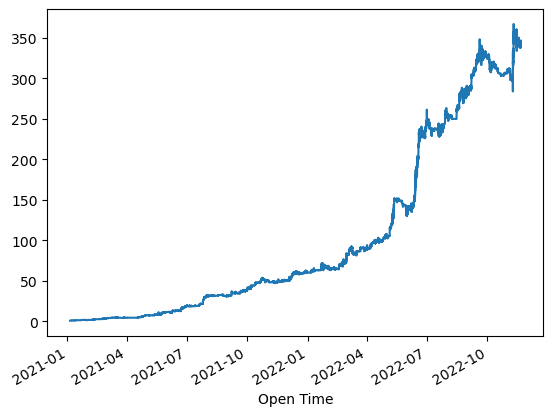

In [274]:
pf.cumulative_returns.plot()

In [236]:
trades = pf.trades.records_readable

In [237]:
trades.columns

Index(['Exit Trade Id', 'Column', 'Size', 'Entry Order Id', 'Entry Index',
       'Avg Entry Price', 'Entry Fees', 'Exit Order Id', 'Exit Index',
       'Avg Exit Price', 'Exit Fees', 'PnL', 'Return', 'Direction', 'Status',
       'Position Id'],
      dtype='object')

In [238]:
pd.set_option('display.max_columns', None)

In [239]:
trades['Return'].cumsum()

0     -0.093568
1      0.069835
2      0.079223
3      0.119176
4      0.292235
5      0.479242
6      0.681068
7      0.664205
8      0.648885
9      0.664747
10     0.618195
11     0.727713
12     0.739285
13     0.682467
14     0.684473
15     0.665843
16     0.659420
17     0.621389
18     0.596163
19     0.605308
20     0.661325
21     0.789655
22     0.725321
23     0.738717
24     0.743559
25     0.942702
26     1.006950
27     1.121159
28     1.123540
29     1.126232
30     1.126321
31     1.122834
32     1.118541
33     1.241230
34     1.436890
35     1.557385
36     1.486426
37     1.558936
38     1.492381
39     1.470659
40     1.485587
41     1.474581
42     1.549354
43     1.615579
44     1.608512
45     1.631505
46     1.650737
47     1.631495
48     1.699710
49     1.702695
50     1.802934
51     1.991144
52     2.339177
53     2.245478
54     2.208691
55     2.353065
56     2.457167
57     2.479185
58     2.484244
59     2.466179
60     2.462894
61     2.504543
62     2

In [240]:
trades[[ 'Size', 'Entry Index',
       'Avg Entry Price',  'Exit Index',
         'Direction', 'Status','Avg Exit Price','PnL','Return', 
       'Position Id']]

,Size,Entry Index,Avg Entry Price,Exit Index,Direction,Status,Avg Exit Price,PnL,Return,Position Id
0,0.003234,2021-01-05 04:15:00+00:00,30921.37,2021-01-06 02:51:00+00:00,Short,Closed,33814.61,-9.356765,-0.093568,0
1,0.002681,2021-01-06 02:51:00+00:00,33814.61,2021-01-07 18:19:00+00:00,Long,Closed,39340.00,14.811326,0.163402,1
2,0.002681,2021-01-07 18:19:00+00:00,39340.00,2021-01-07 18:22:00+00:00,Short,Closed,38970.68,0.989997,0.009388,2
3,0.002731,2021-01-07 18:22:00+00:00,38970.68,2021-01-10 03:21:00+00:00,Long,Closed,40527.68,4.252792,0.039953,3
4,0.002731,2021-01-10 03:21:00+00:00,40527.68,2021-01-11 21:02:00+00:00,Short,Closed,33513.98,19.157228,0.173059,4
5,0.003875,2021-01-11 21:02:00+00:00,33513.98,2021-01-14 15:36:00+00:00,Long,Closed,39781.31,24.283642,0.187006,5
6,0.003875,2021-01-14 15:36:00+00:00,39781.31,2021-01-22 05:29:00+00:00,Short,Closed,31752.39,31.109167,0.201826,6
7,0.005834,2021-01-22 05:29:00+00:00,31752.39,2021-01-22 07:22:00+00:00,Long,Closed,31216.94,-3.123882,-0.016863,7
8,0.005834,2021-01-22 07:22:00+00:00,31216.94,2021-01-23 23:43:00+00:00,Short,Closed,31695.18,-2.790112,-0.015320,8
9,0.005658,2021-01-23 23:43:00+00:00,31695.18,2021-01-26 10:31:00+00:00,Long,Closed,32197.92,2.844536,0.015862,9


<Axes: xlabel='Open Time'>

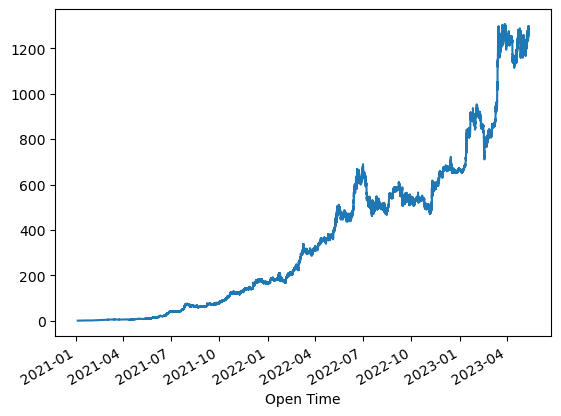

In [233]:
pf.cumulative_returns.plot()

In [154]:
pf.save('portfolio.pkl')

PosixPath('portfolio.pkl')

In [198]:
pf.stats().to_csv('stats-full.csv')

# Hyperparameter Tuning

### Grid Search Method
#### DONT RUN WITHOUT GPU

In [ ]:
from sklearn.model_selection import GridSearchCV

# Specify hyperparameters to tune and their respective ranges
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 500, 1000],
    'model__max_depth': [3, 5, 7],
    'model__min_child_weight': [1, 5, 10],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 1.0]
    # add other parameters here
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="r2", n_jobs=-1, verbose=10)
grid_search.fit(X, y)

# Best parameters and score from grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


### Randomized Search

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Specify hyperparameters to tune and their respective distributions
param_dist = {
    'model__learning_rate': uniform(0.01, 0.2),
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight': randint(1, 10),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    # add other parameters here
}

# Perform randomized search
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=30, cv=cv, scoring="r2", n_jobs=-1, verbose=10, random_state=42)
random_search.fit(X, y)

# Best parameters and score from random search
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


Fitting 37 folds for each of 30 candidates, totalling 1110 fits
[CV 2/37; 1/30] START model__colsample_bytree=0.6872700594236812, model__learning_rate=0.20014286128198325, model__max_depth=5, model__min_child_weight=8, model__n_estimators=800, model__subsample=0.7984250789732434
[CV 1/37; 1/30] START model__colsample_bytree=0.6872700594236812, model__learning_rate=0.20014286128198325, model__max_depth=5, model__min_child_weight=8, model__n_estimators=800, model__subsample=0.7984250789732434
[CV 4/37; 1/30] START model__colsample_bytree=0.6872700594236812, model__learning_rate=0.20014286128198325, model__max_depth=5, model__min_child_weight=8, model__n_estimators=800, model__subsample=0.7984250789732434
[CV 3/37; 1/30] START model__colsample_bytree=0.6872700594236812, model__learning_rate=0.20014286128198325, model__max_depth=5, model__min_child_weight=8, model__n_estimators=800, model__subsample=0.7984250789732434
[CV 5/37; 1/30] START model__colsample_bytree=0.6872700594236812, model_

Mean Squared Error (MSE): 0.0029896802502135554
Root Mean Squared Error (RMSE): 0.05467796859991742
Mean Absolute Error (MAE): 0.04177301527135101
R-squared: -0.12356652583990857


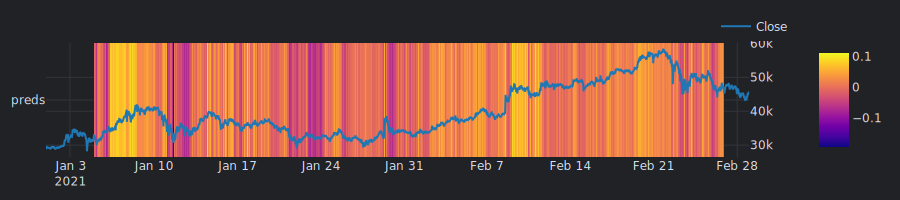

In [34]:
# Fit and predict with the best estimator
test_labels = []
test_preds = []
for split in X_slices.index.unique(level="split"):  
    X_train_slice = X_slices[(split, "train")]  
    y_train_slice = y_slices[(split, "train")]
    X_test_slice = X_slices[(split, "test")]
    y_test_slice = y_slices[(split, "test")]

    slice_pipeline = random_search.best_estimator_.fit(X_train_slice, y_train_slice)  
    test_pred = slice_pipeline.predict(X_test_slice)  
    test_pred = pd.Series(test_pred, index=y_test_slice.index)
    test_labels.append(y_test_slice)
    test_preds.append(test_pred)

test_labels = pd.concat(test_labels).rename("labels")  
test_preds = pd.concat(test_preds).rename("preds")

# Show the accuracy of the predictions
# Assuming test_labels and test_preds are your true and predicted values
mse = mean_squared_error(test_labels, test_preds)
rmse = np.sqrt(mse)  # or use mean_squared_error with squared=False
mae = mean_absolute_error(test_labels, test_preds)
r2 = r2_score(test_labels, test_preds)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Visualize the predictions as a heatmap plotted against the price
data.close.vbt.overlay_with_heatmap(test_preds).show_svg()


Start                         2021-01-05 00:43:00+00:00
End                           2021-02-26 20:44:00+00:00
Period                                             7400
Start Value                                       100.0
Min Value                                     97.786713
Max Value                                    127.232238
End Value                                    117.421212
Total Return [%]                              17.421212
Benchmark Return [%]                          43.421736
Total Time Exposure [%]                       19.864865
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              23.143133
Max Drawdown Duration                            6461.0
Total Orders                                        128
Total Fees Paid                                     0.0
Total Trades                                         64
Win Rate [%]                                     40.625
Best Trade [%]                                20

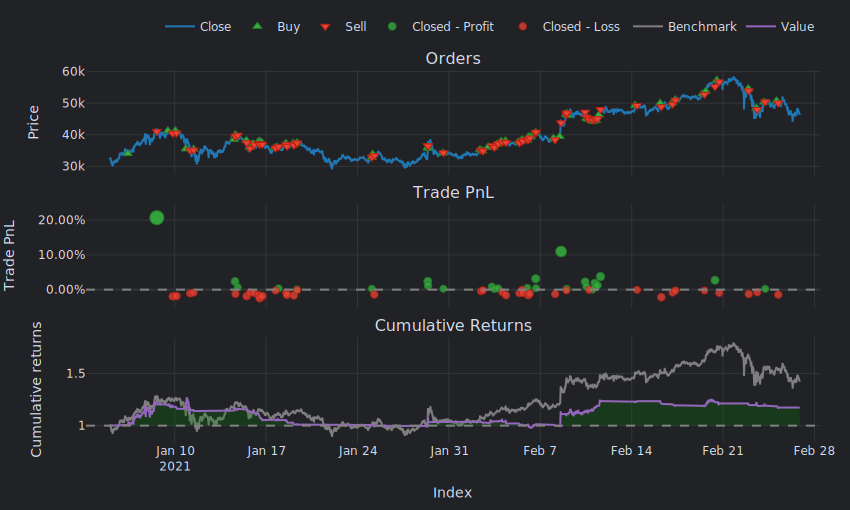

In [47]:
pf = vbt.Portfolio.from_signals(
    data.close[test_preds.index], # use only the test set
    test_preds > 0.05, # long when probability of price increase is greater than 2%
    test_preds < 0.02, # short when probability prediction is less than -5%
    direction="LongOnly" # long and short
)
print(pf.stats())
pf.plot().show_svg()


In [36]:
pf.trades.records_readable

,Exit Trade Id,Column,Size,Entry Order Id,Entry Index,Avg Entry Price,Entry Fees,Exit Order Id,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,0.004411,0,2023-01-27 01:41:00+00:00,22670.3,0.0,1,2023-02-02 22:00:00+00:00,23494.0,0.0,3.633388,0.036334,Long,Closed,0
1,1,0,0.004411,1,2023-02-02 22:00:00+00:00,23494.0,0.0,2,2023-02-03 11:12:00+00:00,23474.8,0.0,0.084692,0.000817,Short,Closed,1
2,2,0,0.004418,2,2023-02-03 11:12:00+00:00,23474.8,0.0,3,2023-02-05 17:41:00+00:00,22912.3,0.0,-2.485279,-0.023962,Long,Closed,2
3,3,0,0.004418,3,2023-02-05 17:41:00+00:00,22912.3,0.0,4,2023-02-05 22:26:00+00:00,23008.3,0.0,-0.424154,-0.004190,Short,Closed,3
4,4,0,0.004381,4,2023-02-05 22:26:00+00:00,23008.3,0.0,5,2023-02-08 16:18:00+00:00,22783.8,0.0,-0.983625,-0.009757,Long,Closed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,84,0,0.003476,84,2023-04-03 21:48:00+00:00,27714.5,0.0,85,2023-04-07 07:56:00+00:00,27829.2,0.0,0.398667,0.004139,Long,Closed,84
85,85,0,0.003476,85,2023-04-07 07:56:00+00:00,27829.2,0.0,86,2023-04-07 12:01:00+00:00,27909.6,0.0,-0.279449,-0.002889,Short,Closed,85
86,86,0,0.003456,86,2023-04-07 12:01:00+00:00,27909.6,0.0,87,2023-04-12 05:00:00+00:00,29910.9,0.0,6.915921,0.071707,Long,Closed,86
87,87,0,0.003456,87,2023-04-12 05:00:00+00:00,29910.9,0.0,88,2023-04-12 12:27:00+00:00,30318.2,0.0,-1.407512,-0.013617,Short,Closed,87
